In [6]:
import os
import requests
from pathlib import Path
from zipfile import ZipFile
from io import BytesIO

def download_heart_disease_dataset(save_dir: str | Path = "./data", force_download: bool = False) -> Path:
    """Download the Heart Disease UCI Dataset and return the data directory.

    - Downloads the official UCI Heart Disease archive ZIP
    - Extracts it into ``save_dir``
    - Returns the path that contains files like ``processed.cleveland.data``
    """
    save_path = Path(save_dir)
    save_path.mkdir(parents=True, exist_ok=True)

    # If data directory already has the key files, reuse it
    key_file = save_path / "processed.cleveland.data"
    if key_file.exists() and not force_download:
        print(f"Dataset already present at: {save_path}")
        return save_path

    url = "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"

    try:
        print("Downloading Heart Disease dataset from UCI Repository...")
        response = requests.get(url, timeout=60)
        response.raise_for_status()

        print(f"Extracting dataset to: {save_path}")
        with ZipFile(BytesIO(response.content)) as zip_file:
            zip_file.extractall(save_path)

        # After extraction, confirm key file(s) exist
        if not key_file.exists():
            # Some mirrors may have slightly different names; fall back to any *.data file
            data_candidates = list(save_path.glob("*.data"))
            if not data_candidates:
                raise FileNotFoundError(
                    f"Expected 'processed.cleveland.data' or any '*.data' file in {save_path}, "
                    "but none were found after extraction.",
                )
            else:
                print("Warning: 'processed.cleveland.data' not found; using first .data file present.")

        files = list(save_path.glob("*"))
        print(f"\nDataset directory: {save_path}")
        print(f"Contains {len(files)} items:")
        for f in sorted(files)[:20]:
            print(f"  - {f.name}")
        if len(files) > 20:
            print(f"  ... and {len(files) - 20} more")

        return save_path

    except requests.exceptions.RequestException as e:
        print(f"✗ Error downloading dataset: {e}")
        raise
    except Exception as e:
        print(f"✗ Error extracting dataset: {e}")
        raise

# Example usage inside notebook
dataset_path = download_heart_disease_dataset()
print(f"\nDataset is ready at: {dataset_path}")


Dataset already present at: data

Dataset is ready at: data


In [7]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def load_raw_heart_data(data_dir: str | Path = "./data") -> pd.DataFrame:
    """Load the raw Heart Disease dataset from the local directory.

    This assumes you've already downloaded the UCI Heart Disease dataset
    into ``data_dir`` using ``download_heart_disease_dataset``.

    We directly target the standard UCI file ``processed.cleveland.data``
    which is present in the archive and is the most commonly used variant.
    """
    data_dir = Path(data_dir)

    data_file = data_dir / "processed.cleveland.data"
    if not data_file.exists():
        raise FileNotFoundError(
            f"Expected file '{data_file.name}' not found in {data_dir}. "
            "Make sure the dataset was downloaded and extracted correctly.",
        )

    print(f"Using data file: {data_file}")

    column_names = [
        "age",
        "sex",
        "cp",
        "trestbps",
        "chol",
        "fbs",
        "restecg",
        "thalach",
        "exang",
        "oldpeak",
        "slope",
        "ca",
        "thal",
        "target",
    ]

    df = pd.read_csv(data_file, header=None, names=column_names)
    print(f"\n📊 Loaded raw dataset: {df.shape[0]} rows, {df.shape[1]} columns")
    
    # Print statistics of cleanup and pre-processing
    print("\n" + "="*60)
    print("DATA CLEANUP & PREPROCESSING STATISTICS")
    print("="*60)
    
    # Original data info
    print(f"\n1. Original Dataset:")
    print(f"   - Total rows: {df.shape[0]}")
    print(f"   - Total columns: {df.shape[1]}")
    
    # Missing values
    missing_markers = (df == "?").sum()
    total_missing = missing_markers.sum()
    if total_missing > 0:
        print(f"\n2. Missing Values (marked as '?'):")
        print(f"   - Total missing values: {total_missing}")
        for col in missing_markers[missing_markers > 0].index:
            print(f"   - {col}: {missing_markers[col]} missing")
    
    # Target distribution
    print("\n3. Target Variable Distribution:")
    print(f"   - Original target values: {df['target'].unique()}")
    counts_str = df['target'].value_counts().to_string(header=False, index=True)
    counts_str = counts_str.replace("\n", "\n     ")
    print("   - Value counts:\n" + counts_str)
    
    return df


def clean_and_preprocess_heart_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean the Heart Disease data (missing values + numeric conversion + binary target).

    This function DOES NOT perform encoding, scaling or train/test splitting.
    It returns a cleaned dataframe with:
    - no missing values
    - numeric columns converted where possible
    - 'target' column binarized (0 = no disease, 1 = disease)
    """

    # Replace UCI missing-value marker '?' with NaN
    df = df.replace("?", pd.NA)

    # Convert all non-target columns to numeric safely
    for col in df.columns:
        if col == "target":
            continue
        try:
            df[col] = pd.to_numeric(df[col])
        except Exception:
            # If conversion fails entirely, leave column as-is (will be treated as categorical)
            pass

    # Drop rows with any missing values (simple strategy for this assignment)
    df = df.dropna().reset_index(drop=True)

    # Ensure target is binary: in Cleveland data, values > 0 indicate presence of disease
    if "target" in df.columns:
        df["target"] = (df["target"] > 0).astype(int)
    else:
        raise KeyError("Expected 'target' column in dataframe")

    return df


def prepare_ml_features(
    df: pd.DataFrame,
    scaler: StandardScaler | None = None,
) -> tuple[pd.DataFrame, pd.Series, StandardScaler]:
    """Prepare final ML features (encoding + scaling) from a CLEANED dataframe.

    Input:
    - df: cleaned dataframe (output of clean_and_preprocess_heart_data),
           must contain a binary 'target' column.
    - scaler: optional existing StandardScaler; if None, a new one is fitted.

    Output:
    - X: encoded & scaled feature matrix (pandas DataFrame)
    - y: target Series
    - scaler: fitted StandardScaler
    """
    if "target" not in df.columns:
        raise KeyError("Expected 'target' column in dataframe for feature preparation")

    # Separate features and target
    X = df.drop(columns=["target"])
    y = df["target"]

    # Identify numeric and categorical columns
    numeric_cols = X.select_dtypes(include=["int64", "float64", "Int64", "Float64"]).columns
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    # One-hot encode categorical features
    if categorical_cols:
        X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Fit scaler if not provided, then transform numeric columns
    if scaler is None:
        scaler = StandardScaler()
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    else:
        X[numeric_cols] = scaler.transform(X[numeric_cols])

    return X, y, scaler


def train_test_split_features(
    X: pd.DataFrame,
    y: pd.Series,
    test_size: float = 0.2,
    random_state: int = 42,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Perform a stratified train/test split on prepared features."""
    return train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
)



# Example modular pipeline usage in this notebook
try:
    # 1. Load raw data
    raw_df = load_raw_heart_data(data_dir=Path(dataset_path))

    # 2. Clean (handle missing values, numeric conversion, binary target)
    cleaned_df = clean_and_preprocess_heart_data(raw_df)

    # 3. Prepare final ML features (encoding + scaling)
    X, y, scaler = prepare_ml_features(cleaned_df)

    # 4. Train/test split
    X_train, X_test, y_train, y_test = train_test_split_features(X, y)

    print("Data cleaning and feature preparation complete.")
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
except Exception as e:
    print(f"Error during preprocessing: {e}")


Using data file: data/processed.cleveland.data

📊 Loaded raw dataset: 303 rows, 14 columns

DATA CLEANUP & PREPROCESSING STATISTICS

1. Original Dataset:
   - Total rows: 303
   - Total columns: 14

2. Missing Values (marked as '?'):
   - Total missing values: 6
   - ca: 4 missing
   - thal: 2 missing

3. Target Variable Distribution:
   - Original target values: [0 2 1 3 4]
   - Value counts:
0    164
     1     55
     2     36
     3     35
     4     13
Data cleaning and feature preparation complete.
Train shape: (237, 13), Test shape: (60, 13)


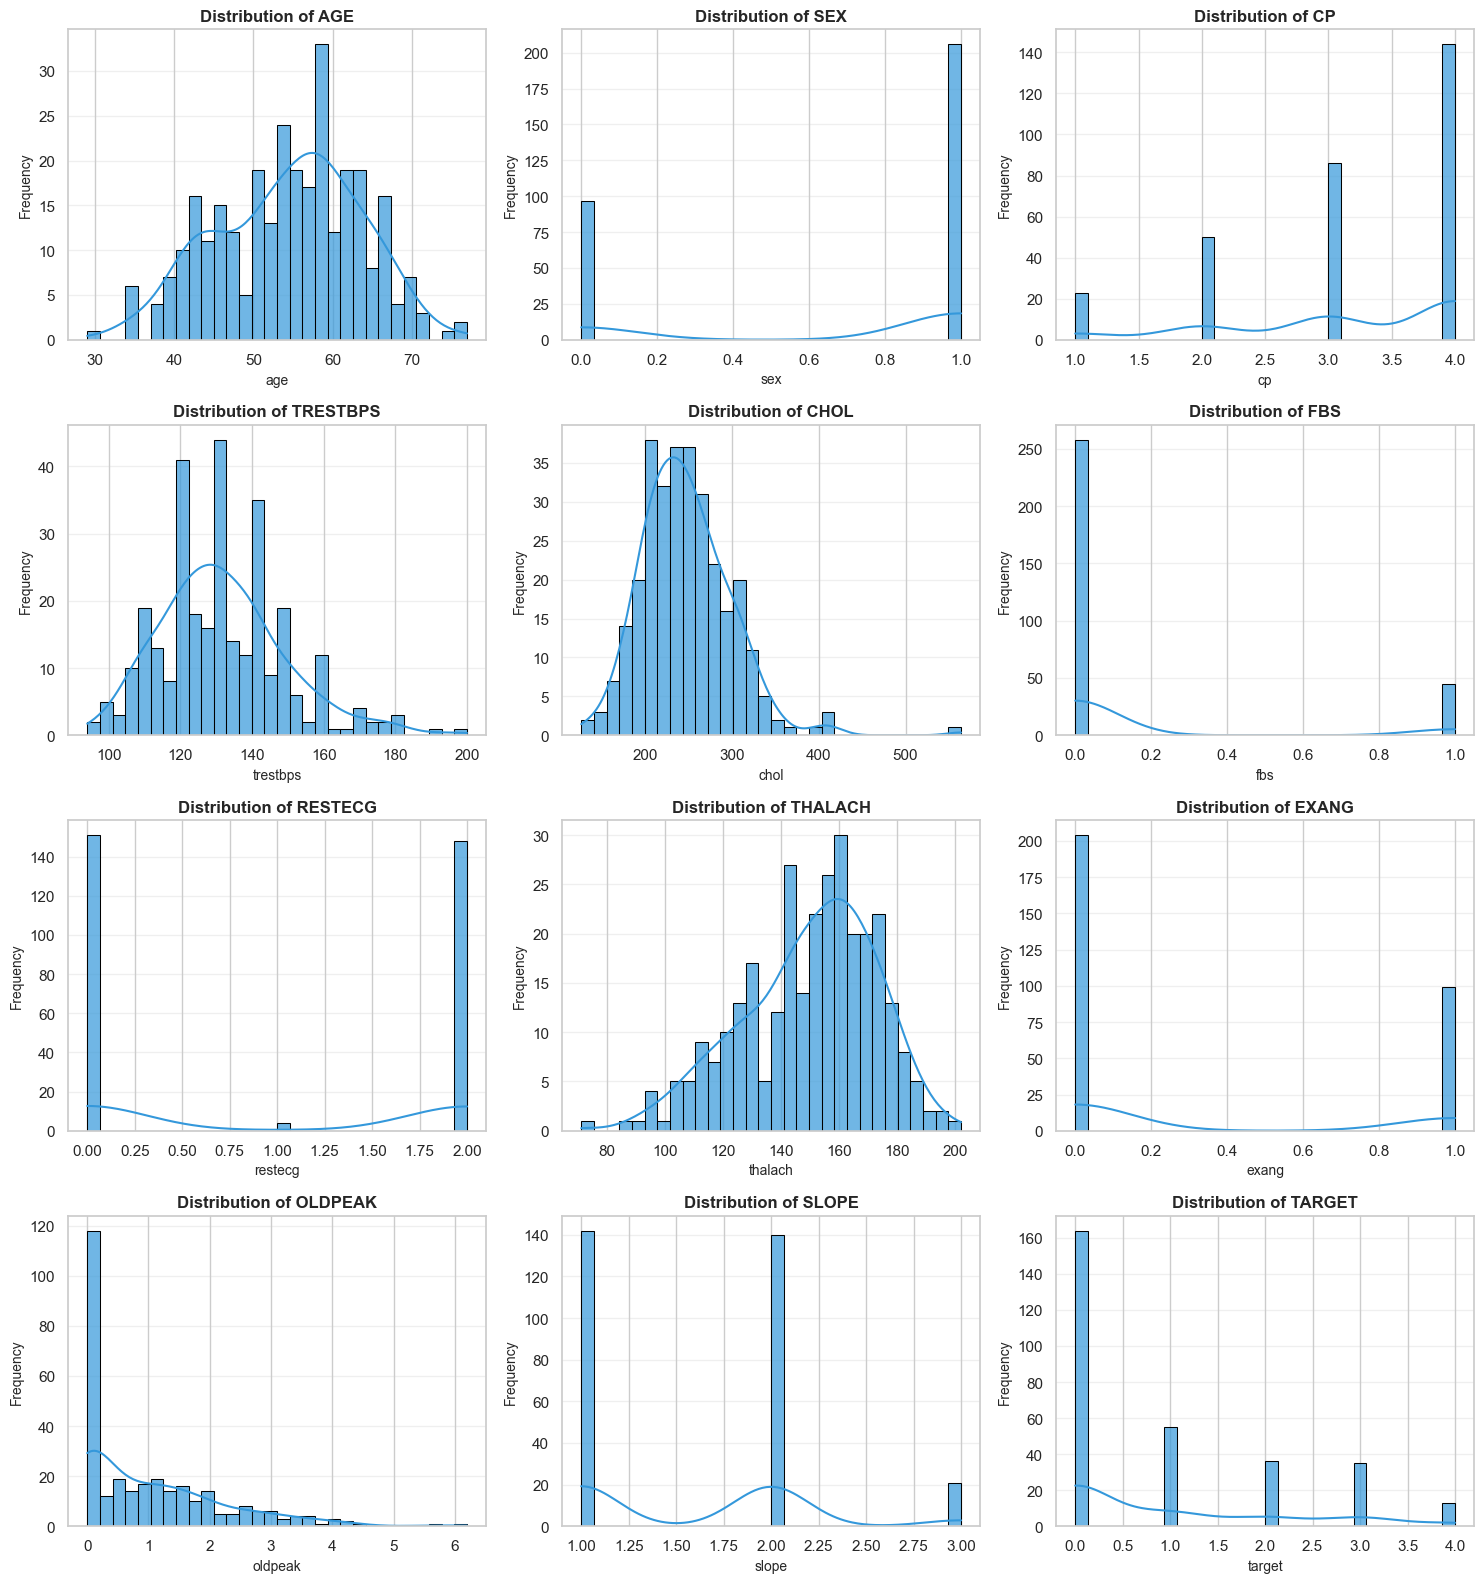

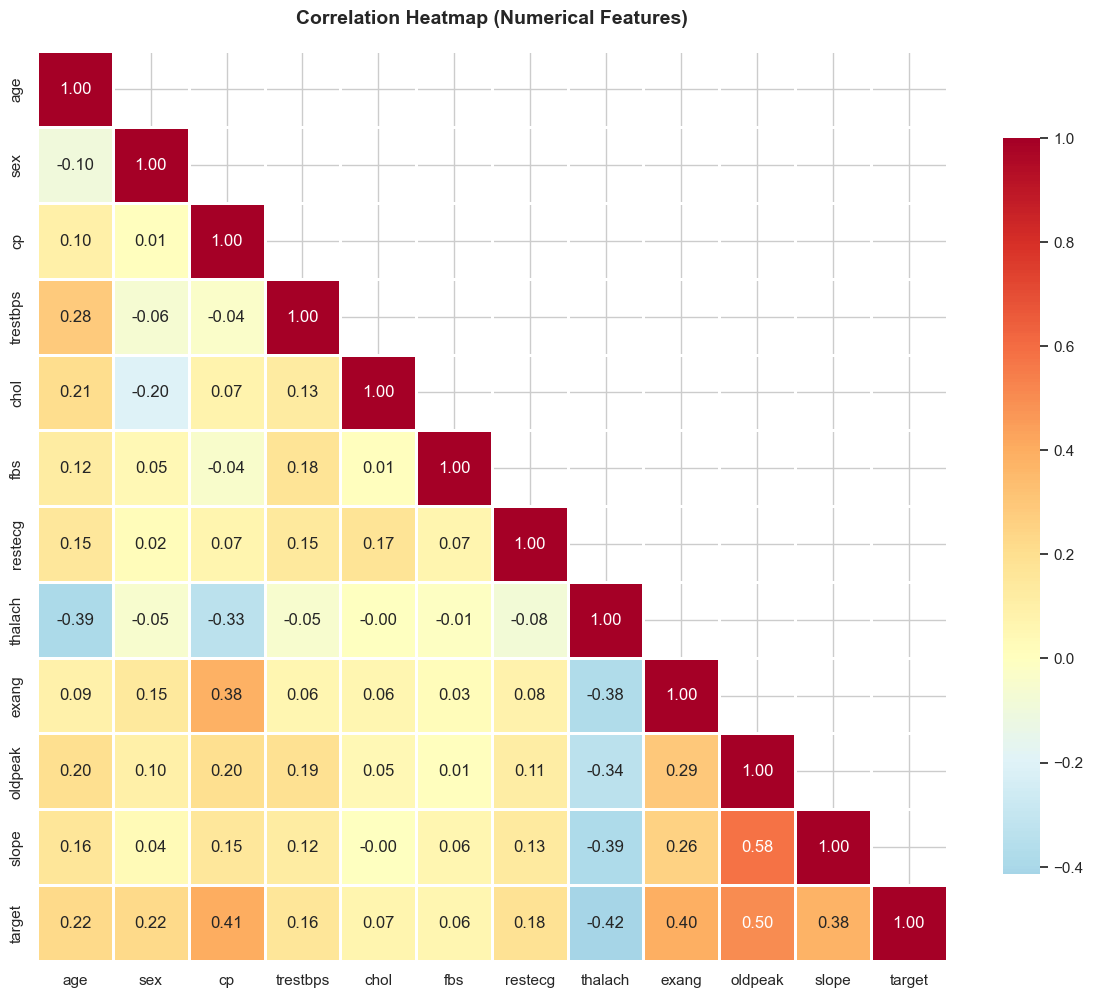

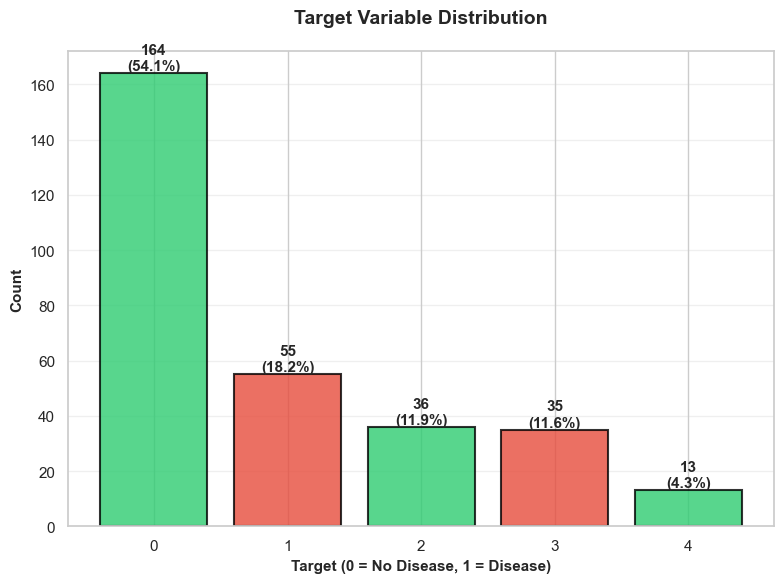

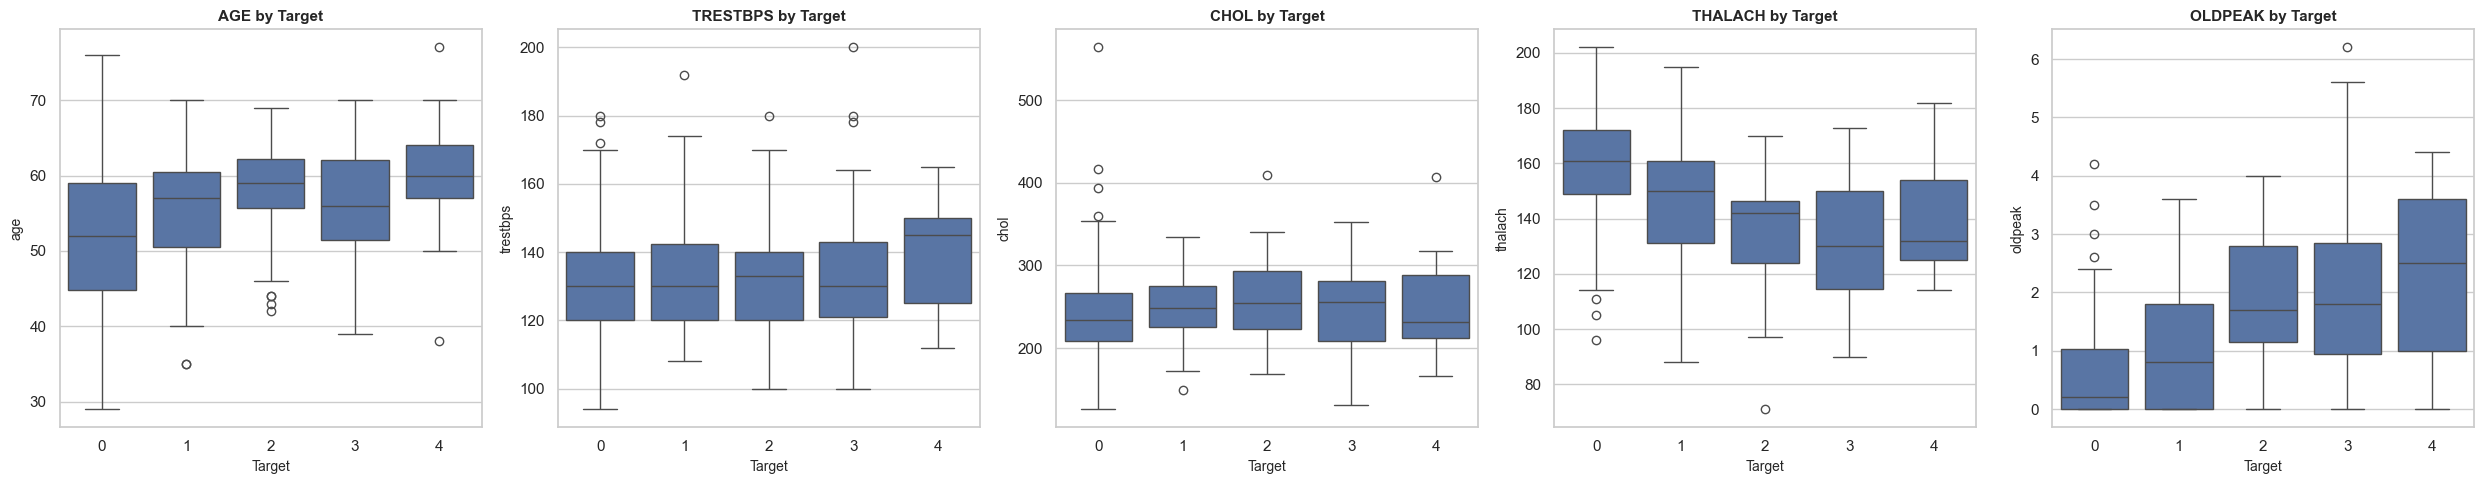

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def perform_eda_heart_data(df: pd.DataFrame) -> None:
    """Perform basic EDA with professional visualizations on the Heart Disease data.

    Visuals:
    - Histograms for key numerical features
    - Correlation heatmap
    - Class balance bar plot for target
    - Box plots of key features by target
    """
    sns.set(style="whitegrid", context="notebook")

    # 1. Enhanced Histograms for numerical features with better styling
    numeric_cols = df.select_dtypes(include=["int64", "float64", "Int64", "Float64"]).columns
    if len(numeric_cols) > 0:
        n_cols = 3
        n_rows = int((len(numeric_cols) + n_cols - 1) / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes]
        
        for i, col in enumerate(numeric_cols):
            sns.histplot(df[col].dropna(), kde=True, bins=30, color="#3498db", 
                        edgecolor='black', alpha=0.7, ax=axes[i])
            axes[i].set_title(f'Distribution of {col.upper()}', fontsize=12, fontweight='bold')
            axes[i].set_xlabel(col, fontsize=10)
            axes[i].set_ylabel('Frequency', fontsize=10)
            axes[i].grid(axis='y', alpha=0.3)
        
        # Hide extra subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()

    # 2. Enhanced Correlation heatmap with annotations
    if len(numeric_cols) > 1:
        plt.figure(figsize=(12, 10))
        corr = df[numeric_cols].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
        sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap="RdYlBu_r", 
                   center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        plt.title("Correlation Heatmap (Numerical Features)", fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

    # 3. Enhanced Class balance with percentages
    if "target" in df.columns:
        fig, ax = plt.subplots(figsize=(8, 6))
        target_counts = df["target"].value_counts().sort_index()
        colors = ['#2ecc71', '#e74c3c']
        bars = ax.bar(target_counts.index, target_counts.values, color=colors, 
                     edgecolor='black', linewidth=1.5, alpha=0.8)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            percentage = (height / len(df)) * 100
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}\n({percentage:.1f}%)',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        ax.set_title("Target Variable Distribution", fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel("Target (0 = No Disease, 1 = Disease)", fontsize=11, fontweight='bold')
        ax.set_ylabel("Count", fontsize=11, fontweight='bold')
        ax.set_xticks(sorted(target_counts.index.tolist()))
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 4. Additional: Box plots for key features by target (uses seaborn default palette for many classes)
    if "target" in df.columns and len(numeric_cols) > 1:
        key_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
        available_features = [f for f in key_features if f in numeric_cols]
        
        if available_features:
            fig, axes = plt.subplots(1, len(available_features), figsize=(5*len(available_features), 5))
            if len(available_features) == 1:
                axes = [axes]
            
            for i, feature in enumerate(available_features):
                sns.boxplot(x='target', y=feature, data=df, ax=axes[i])
                axes[i].set_title(f'{feature.upper()} by Target', fontsize=11, fontweight='bold')
                axes[i].set_xlabel('Target', fontsize=10)
                axes[i].set_ylabel(feature, fontsize=10)
            
            plt.tight_layout()
            plt.show()



## Example EDA usage (call after loading raw_df)
perform_eda_heart_data(raw_df)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


def train_logistic_regression(X_train, y_train):
    """Build and train a Logistic Regression classifier on the training data.

    This is the *final* model trained after you have inspected cross-validation results.
    """
    model = LogisticRegression(max_iter=1000, n_jobs=-1, solver="lbfgs")
    model.fit(X_train, y_train)
    return model


def train_random_forest(X_train, y_train, n_estimators: int = 200, random_state: int = 42):
    """Build and train a Random Forest classifier on the training data.

    Parameters
    ----------
    X_train, y_train : training data
    n_estimators : number of trees
    random_state : random seed for reproducibility
    """
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1,
        class_weight="balanced",
    )
    model.fit(X_train, y_train)
    return model


def train_decision_tree(X_train, y_train, max_depth: int | None = None, random_state: int = 42):
    """Build and train a Decision Tree classifier on the training data.

    Parameters
    ----------
    X_train, y_train : training data
    max_depth : limit tree depth (None = unlimited)
    random_state : random seed for reproducibility
    """
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        random_state=random_state,
        class_weight="balanced",
    )
    model.fit(X_train, y_train)
    return model


def evaluate_classification_model(model, X_train, y_train, X_test, y_test, model_name: str = "Model") -> dict:
    """Evaluate a fitted binary classification model on train and test sets.

    Metrics: accuracy, precision, recall, F1-score, ROC-AUC (if available).
    Returns a dict of metrics and also prints a brief report.
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Some models may not support predict_proba (e.g., some SVM variants); guard accordingly
    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_test_proba)
    else:
        roc_auc = float("nan")

    metrics = {
        "train_accuracy": accuracy_score(y_train, y_train_pred),
        "test_accuracy": accuracy_score(y_test, y_test_pred),
        "test_precision": precision_score(y_test, y_test_pred, zero_division=0),
        "test_recall": recall_score(y_test, y_test_pred, zero_division=0),
        "test_f1": f1_score(y_test, y_test_pred, zero_division=0),
        "test_roc_auc": roc_auc,
    }

    print(f"\n===== {model_name} Performance (Hold-out Test Set) =====")
    print(f"Train Accuracy: {metrics['train_accuracy']:.3f}")
    print(f"Test  Accuracy: {metrics['test_accuracy']:.3f}")
    print(f"Precision:     {metrics['test_precision']:.3f}")
    print(f"Recall:        {metrics['test_recall']:.3f}")
    print(f"F1-score:      {metrics['test_f1']:.3f}")
    if not (roc_auc != roc_auc):  # check for NaN
        print(f"ROC-AUC:       {metrics['test_roc_auc']:.3f}")
    print("\nClassification report (test set):")
    print(classification_report(y_test, y_test_pred, zero_division=0))

    return metrics


def cross_validate_models(X, y, cv_splits: int = 5, random_state: int = 42) -> pd.DataFrame:
    """Run cross-validation for Logistic Regression, Random Forest and Decision Tree.

    Uses StratifiedKFold and reports mean +/- std for:
    - accuracy
    - precision
    - recall
    - F1-score
    - ROC-AUC
    Returns a pandas DataFrame summarizing model selection metrics.
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    scoring = {
        "accuracy": "accuracy",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
        "roc_auc": "roc_auc",
    }

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1, solver="lbfgs"),
        "Random Forest": RandomForestClassifier(
            n_estimators=200,
            random_state=random_state,
            n_jobs=-1,
            class_weight="balanced",
        ),
        "Decision Tree": DecisionTreeClassifier(
            max_depth=None,
            random_state=random_state,
            class_weight="balanced",
        ),
    }

    rows = []
    for name, model in models.items():
        print(f"\nRunning {cv_splits}-fold cross-validation for {name}...")
        cv_results = cross_validate(
            model, X, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1
        )

        row = {"model": name}
        for metric in scoring.keys():
            scores = cv_results[f"test_{metric}"]
            row[f"{metric}_mean"] = scores.mean()
            row[f"{metric}_std"] = scores.std()
        rows.append(row)

    results_df = pd.DataFrame(rows)
    print("\n===== Cross-Validation Summary (Model Selection) =====")
    print(results_df.round(3))
    return results_df


def log_cv_results_to_mlflow(cv_results_df: pd.DataFrame):
    """Log cross-validation summary table as an MLflow artifact (CSV)."""
    cv_results_df.to_csv("cv_results_summary.csv", index=False)
    mlflow.log_artifact("cv_results_summary.csv", artifact_path="cv_results")


def log_model_run_to_mlflow(model_name: str, params: dict, metrics: dict):
    """Log parameters and metrics for a single trained model to MLflow."""
    mlflow.log_param("model_name", model_name)
    for p_name, p_val in params.items():
        mlflow.log_param(p_name, p_val)
    for m_name, m_val in metrics.items():
        mlflow.log_metric(m_name, float(m_val))


def log_confusion_matrix_plot(model, X_test, y_test, model_name: str):
    """Create and log a simple confusion matrix heatmap as an MLflow artifact."""
    from sklearn.metrics import confusion_matrix

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plot_path = f"confusion_matrix_{model_name.replace(' ', '_').lower()}.png"
    plt.savefig(plot_path)
    plt.close()
    mlflow.log_artifact(plot_path, artifact_path="plots")



def save_final_model(
    model,
    model_name: str,
    output_dir: str | Path = "artifacts",
    save_pickle: bool = True,
    save_mlflow: bool = True,
    save_onnx: bool = False,
    X_sample=None,
):
    """Save the final trained model in multiple reusable formats.

    - Always supports local pickle and MLflow model logging (if an MLflow run is active)
    - Optionally supports ONNX export if ``skl2onnx`` is installed and ``X_sample`` is provided
    """
    import pickle
    import numpy as np

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    safe_name = model_name.replace(" ", "_").lower()

    # 1. Local pickle
    if save_pickle:
        pkl_path = output_dir / f"{safe_name}.pkl"
        with open(pkl_path, "wb") as f:
            pickle.dump(model, f)
        print(f"Saved pickle model to: {pkl_path}")

    # 2. MLflow model (if run is active)
    if save_mlflow:
        try:
            import mlflow.sklearn as mls

            mls.log_model(model, artifact_path=f"{safe_name}_mlflow_model")
            print(
                f"Logged model to MLflow under artifact path '{safe_name}_mlflow_model'"
            )
        except Exception as e:
            print(f"Warning: could not log model to MLflow: {e}")

    # 3. Optional ONNX export
    if save_onnx:
        try:
            if X_sample is None:
                raise ValueError("X_sample must be provided to export ONNX model.")

            from skl2onnx import convert_sklearn
            from skl2onnx.common.data_types import FloatTensorType

            # Take a small numeric sample for schema inference
            if hasattr(X_sample, "values"):
                X_np = X_sample.values.astype("float32")
            else:
                X_np = np.asarray(X_sample, dtype="float32")

            initial_type = [("input", FloatTensorType([None, X_np.shape[1]]))]
            onnx_model = convert_sklearn(model, initial_types=initial_type)
            onnx_path = output_dir / f"{safe_name}.onnx"
            with open(onnx_path, "wb") as f:
                f.write(onnx_model.SerializeToString())
            print(f"Saved ONNX model to: {onnx_path}")
        except Exception as e:
            print(f"Warning: could not export ONNX model: {e}")



# Example model selection, training, evaluation and MLflow logging pipeline
try:
    mlflow.set_experiment("heart_disease_classification")

    # 1. Model selection via cross-validation on the TRAINING data only
    cv_results_df = cross_validate_models(X_train, y_train, cv_splits=5, random_state=42)

    # Log overall CV summary once at the parent run level
    with mlflow.start_run(run_name="model_comparison") as parent_run:
        log_cv_results_to_mlflow(cv_results_df)

        # 2. For each model, start a nested run to log params, metrics and artifacts
        model_configs = [
            ("Logistic Regression", train_logistic_regression, {"model_type": "log_reg"}),
            ("Random Forest", train_random_forest, {"model_type": "random_forest", "n_estimators": 200}),
            ("Decision Tree", train_decision_tree, {"model_type": "decision_tree", "max_depth": None}),
        ]

        for model_name, train_fn, base_params in model_configs:
            with mlflow.start_run(run_name=model_name, nested=True):
                # Train model
                model = train_fn(X_train, y_train)

                # Evaluate model
                metrics = evaluate_classification_model(
                    model, X_train, y_train, X_test, y_test, model_name=model_name
                )

                # Log params & metrics
                log_model_run_to_mlflow(model_name, base_params, metrics)

                # Log confusion matrix plot
                log_confusion_matrix_plot(model, X_test, y_test, model_name)

                # Save the trained model in reusable formats (pickle + MLflow, optional ONNX)
                save_final_model(
                    model,
                    model_name=model_name,
                    output_dir="artifacts",
                    save_pickle=True,
                    save_mlflow=True,
                    save_onnx=False,
                    X_sample=X_train.iloc[:10] if "X_train" in globals() else None,
                )
except Exception as e:
    print(f"Error during model selection/training/evaluation with MLflow: {e}")



Running 5-fold cross-validation for Logistic Regression...

Running 5-fold cross-validation for Random Forest...

Running 5-fold cross-validation for Random Forest...

Running 5-fold cross-validation for Decision Tree...

Running 5-fold cross-validation for Decision Tree...


2025/12/26 12:34:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



===== Cross-Validation Summary (Model Selection) =====
                 model  accuracy_mean  accuracy_std  precision_mean  \
0  Logistic Regression          0.827         0.059           0.849   
1        Random Forest          0.810         0.075           0.833   
2        Decision Tree          0.729         0.098           0.742   

   precision_std  recall_mean  recall_std  f1_mean  f1_std  roc_auc_mean  \
0          0.086        0.769       0.096    0.802   0.068         0.870   
1          0.111        0.760       0.127    0.784   0.083         0.890   
2          0.157        0.679       0.104    0.700   0.094         0.726   

   roc_auc_std  
0        0.068  
1        0.054  
2        0.095  

===== Logistic Regression Performance (Hold-out Test Set) =====
Train Accuracy: 0.852
Test  Accuracy: 0.833
Precision:     0.846
Recall:        0.786
F1-score:      0.815
ROC-AUC:       0.950

Classification report (test set):
              precision    recall  f1-score   support

   

2025/12/26 12:34:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Saved pickle model to: artifacts/random_forest.pkl


2025/12/26 12:34:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged model to MLflow under artifact path 'random_forest_mlflow_model'

===== Decision Tree Performance (Hold-out Test Set) =====
Train Accuracy: 1.000
Test  Accuracy: 0.717
Precision:     0.704
Recall:        0.679
F1-score:      0.691
ROC-AUC:       0.714

Classification report (test set):
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        32
           1       0.70      0.68      0.69        28

    accuracy                           0.72        60
   macro avg       0.72      0.71      0.71        60
weighted avg       0.72      0.72      0.72        60

Saved pickle model to: artifacts/decision_tree.pkl
Logged model to MLflow under artifact path 'decision_tree_mlflow_model'
Logged model to MLflow under artifact path 'decision_tree_mlflow_model'


INFO:     127.0.0.1:62080 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK


In [12]:
import sys
import subprocess

# Start MLflow UI from within the notebook using the current Python interpreter
try:
    cmd = [sys.executable, "-m", "mlflow", "ui", "--host", "127.0.0.1", "--port", "5000"]
    print("Starting MLflow UI with:", " ".join(cmd))
    mlflow_ui_process = subprocess.Popen(cmd)
    print("MLflow UI should now be available at http://127.0.0.1:5000 ",
          f"(PID: {mlflow_ui_process.pid})")
except Exception as e:
    print(f"Error starting MLflow UI: {e}")

Starting MLflow UI with: /Users/saghanta/.pyenv/versions/3.11.14/bin/python -m mlflow ui --host 127.0.0.1 --port 5000
MLflow UI should now be available at http://127.0.0.1:5000  (PID: 8550)


Backend store URI not provided. Using sqlite:///mlflow.db
Registry store URI not provided. Using backend store URI.


2025/12/26 12:34:56 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/26 12:34:56 INFO mlflow.store.db.utils: Updating database tables
2025/12/26 12:34:56 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/26 12:34:56 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/26 12:34:56 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/26 12:34:56 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/26 12:34:56 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/26 12:34:56 INFO mlflow.store.db.utils: Updating database tables
2025/12/26 12:34:56 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/26 12:34:56 INFO alembic.runtime.migration: Will assume non-transactional DDL.
[MLflow] Security middleware enabled with default settings (localhost-only). To allow connections from other hosts, use --host 0.0.0.0 and configure --allowed-hosts and --cors-allo

INFO:     127.0.0.1:62130 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:62133 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:62133 - "GET /static-files/static/js/main.bbdf6ce4.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:62134 - "GET /static-files/static/css/main.280d6c90.css HTTP/1.1" 200 OK
INFO:     127.0.0.1:62133 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:62133 - "GET /static-files/static/js/main.bbdf6ce4.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:62134 - "GET /static-files/static/css/main.280d6c90.css HTTP/1.1" 200 OK
INFO:     127.0.0.1:62134 - "GET /static-files/static/js/3617.10568100.chunk.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:62133 - "GET /static-files/static/js/5759.45405231.chunk.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:62138 - "GET /static-files/static/css/8516.26533251.chunk.css HTTP/1.1" 200 OK
INFO:     127.0.0.1:62139 - "GET /static-files/static/js/8516.2c6c0e64.chunk.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:62134 - "GET /static-files/favicon